<a href="https://colab.research.google.com/github/nomomon/AISIG-course-project/blob/master/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Captioning with Attention

**Author** : Mansur Nurmukhambetov ([@nomomon](https://github.com/nomomon))

This project is a final project for the AI Safety Initiative Groningen course. The goal of the project is to implement an image captioning model with attention. The model is trained on the Flicker8K dataset and is able to generate captions for images.

**Dataset**

Dataset used is Flicker8K dataset – it is a dataset of 8K images that are each paired with 5 different captions which provide clear descriptions of the salient entities and events. The dataset is available here: https://www.kaggle.com/datasets/adityajn105/flickr8k

In [1]:
#@title Kaggle API

from IPython.display import clear_output

username = str(input("username: "))
key = str(input("key: "))

clear_output()

f = open("kaggle.json", "w")
f.write('{"username":"'+username+'","key":"'+key+'"}')
f.close()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d adityajn105/flickr8k
!mkdir data
!unzip flickr8k.zip -d data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer

## Data Analysis

In [ ]:
lables = pd.read_csv('data/captions.txt')

lables.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [ ]:
lables['image'] = lables['image'].apply(lambda x: 'data/images/' + x)

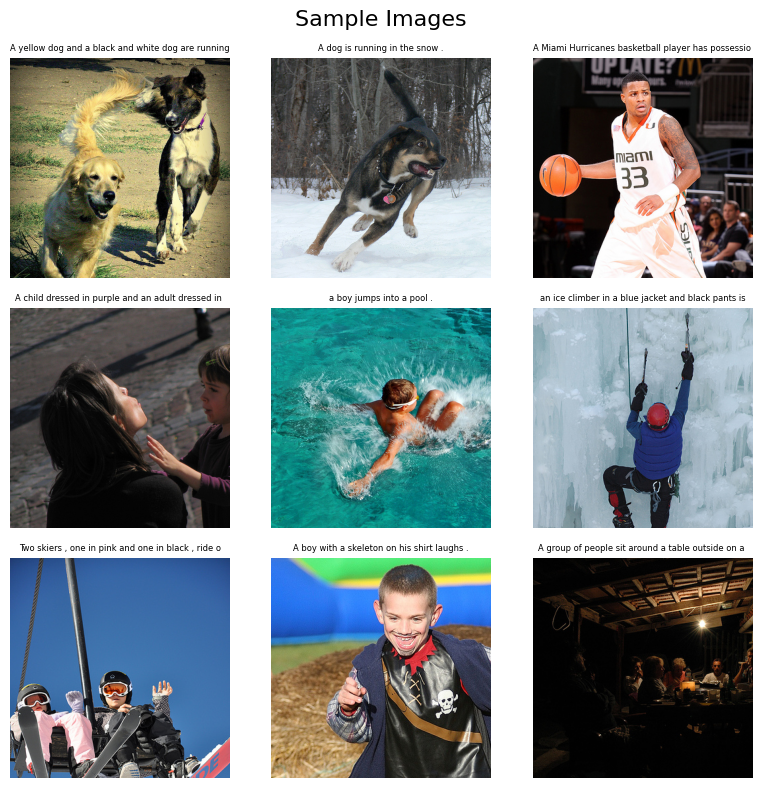

In [ ]:
n = 3
fig, axs = plt.subplots(n, n, figsize=(8, 8))

i=0
for row in lables.sample(n**2).iterrows():
    _, data = row
    img = plt.imread(data['image'])
    w, h, _ = img.shape
    w = min(w, h)
    img = img[:w, :w, :]
    ax = axs[i//n, i%n]
    ax.imshow(img)
    ax.set_title(data['caption'][:50], fontsize=6, wrap=True)
    ax.axis('off')
    i += 1

fig.suptitle('Sample Images', fontsize=16)
plt.tight_layout()

<AxesSubplot: >

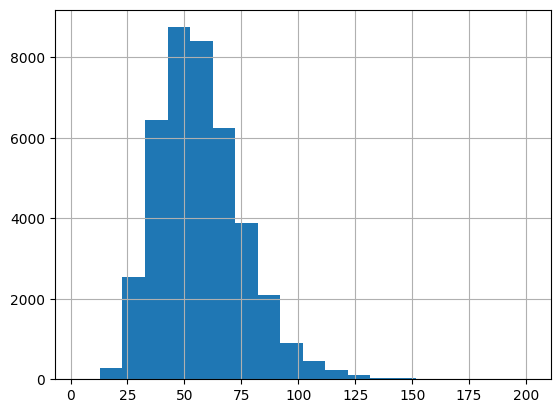

In [ ]:
lables['caption'].str.split("").apply(len).hist(bins=20)

In [ ]:
max_len = 200

In [ ]:
lables['caption'] = (
    lables['caption']
        .str.lower()
        .str.replace('[^\w\s]', ' ')
        .str.replace('[\s+]', ' ')
        .str.strip()
        .str.split("")
        .str.join(" ")
)

/var/folders/s9/0x7864ms0sj16xzqw_gzzh_w0000gn/T/ipykernel_71738/359225055.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  lables['caption']


In [ ]:
# using tf datset generator to load images and captions

tokenizer = Tokenizer(oov_token='<unk>')
tokenizer.fit_on_texts(lables['caption'].values)

tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [ ]:
lables['caption'] = tokenizer.texts_to_sequences(lables['caption'].values)

In [ ]:
num_classes = len(tokenizer.word_index)
num_classes

38

## Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
vocab_size = num_classes
embedding_dim = 256
units = 512
max_caption_length = 200
batch_size = 64
BUFFER_SIZE = 1000
epochs = 10
num_steps = len(lables) // batch_size

learning_rate = 0.001

In [ ]:
# Define the Image Encoder
def build_image_encoder():
    image_input = Input(shape=(224, 224, 3))
    resnet = ResNet50(include_top=False, weights='imagenet', pooling='avg')
    encoded_image = Dense(256, activation='relu')(resnet(image_input))
    return Model(inputs=image_input, outputs=encoded_image)

# Define the Caption Decoder
def build_caption_decoder(vocab_size, max_caption_length):
    caption_input = Input(shape=(max_caption_length,))
    caption_embedding = Embedding(input_dim=vocab_size, output_dim=256)(caption_input)
    decoder_input = Dropout(0.5)(caption_embedding)

    transformer_block = TransformerBlock(256, num_heads=8, ff_dim=512, rate=0.1)
    decoder_output = transformer_block(decoder_input)

    decoder_output = Dense(vocab_size, activation='softmax')(decoder_output)

    return Model(inputs=caption_input, outputs=decoder_output)

# Define the Transformer Block
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embedding_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation='relu'),
            Dense(embedding_dim)
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training=True):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# Define the Image Captioning Model
class ImageCaptioningModel:
    def __init__(self, vocab_size, max_caption_length):
        self.image_encoder = build_image_encoder()
        self.caption_decoder = build_caption_decoder(vocab_size, max_caption_length)

    def compile_model(self, learning_rate):
        optimizer = Adam(learning_rate=learning_rate)
        loss_fn = SparseCategoricalCrossentropy(from_logits=True, reduction='none')
        self.caption_decoder.compile(optimizer=optimizer, loss=loss_fn)

    def train_model(self, train_images, train_captions, tokenizer, epochs, batch_size):
        train_dataset = self.prepare_dataset(train_images, train_captions, tokenizer, batch_size)
        self.caption_decoder.fit(train_dataset, epochs=epochs)

    def prepare_dataset(self, images, captions, tokenizer, batch_size):
        image_features = self.encode_images(images)
        caption_sequences = tokenizer.texts_to_sequences(captions)
        caption_inputs, caption_outputs = self.create_caption_inputs_outputs(caption_sequences)

        dataset = tf.data.Dataset.from_tensor_slices((image_features, caption_inputs, caption_outputs))
        dataset = dataset.shuffle(len(images)).batch(batch_size)

        return dataset

    def encode_images(self, images):
        encoded_images = []
        for image_path in images:
            img = load_img(image_path, target_size=(224, 224))
            img = img_to_array(img)
            img = preprocess_input(img)
            encoded_images.append(img)
        return self.image_encoder.predict(np.array(encoded_images))

    def create_caption_inputs_outputs(self, caption_sequences):
        caption_inputs = []
        caption_outputs = []
        for sequence in caption_sequences:
            for i in range(1, len(sequence)):
                in_seq, out_seq = sequence[:i], sequence[i]
                in_seq = pad_sequences([in_seq], maxlen=max_caption_length, padding='post')[0]
                out_seq = tf.keras.utils.to_categorical([out_seq], num_classes=vocab_size)[0]
                caption_inputs.append(in_seq)
                caption_outputs.append(out_seq)
        return np.array(caption_inputs), np.array(caption_outputs)

# Instantiate the Image Captioning Model
model = ImageCaptioningModel(vocab_size, max_caption_length)
model.compile_model(learning_rate)

# Train the Model
model.train_model(
    lables["image"].values, lables["caption"].values,
    tokenizer, epochs, batch_size
)

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2023-07-10 09:59:32.266087: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-07-10 09:59:32.266546: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


: 

: 